## Imports

In [1]:
import cv2
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, BatchNormalization, GlobalAveragePooling2D, ReLU, RandomFlip, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from dotenv import load_dotenv

## Data Loading

In [2]:
class LoadData:
    """
    LoadData class
    """
    def __init__(self, base_path):
        self.base_path = base_path

    def load_data(self, height, width):
      """
      
      """
      x = []
      y = []

      
      for class_number in range(10):
        class_number_str = 'c' + str(class_number)
        path = os.path.join(self.base_path, 'imgs/data', class_number_str, '*.jpg')
        file_paths = glob.glob(path)  # Gets all file names matching given path.
        sub_x = []
        sub_y = []
        for file_path in file_paths:
            sub_x.append(file_path)
            temp = np.zeros(10)
            temp[class_number] = 1
            sub_y.append(temp)
        self.shuffle_data(sub_x)
        x.append(sub_x)
        y.append(sub_y)
      print("Saved all image paths.")
      return x, y

    def shuffle_data(self, x):
      np.random.shuffle(x)

In [3]:
HEIGHT = 128
WIDTH = 128

load_dotenv()
PATH = os.getenv('PATH_TO_DATA')
x, y = LoadData(PATH).load_data(HEIGHT, WIDTH)

Saved all image paths.


## Data Preprocessing


In [4]:
class PreProcessing:
  """
  Goes through all images, returns preprocessed tensor.
  """

  def __init__(self):
    self.kernel = np.array([[-1, -1, -1],
                  [-1, 8,-1],
                  [-1, -1, -1]])
  
  def get_colour_type(self, img_path):
    image = cv2.imread(img_path)
    if len(image.shape) == 3: return 3
    return 1

  def preprocess_image(self, img_path, height, width, training):
    """
    Function takes the path to the image and applys the preprocessing.
    """

    color_type = self.get_colour_type(img_path)

    if color_type == 1:
        img = cv2.imread(img_path, 0)
        img_gray = cv2.threshold(img,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU) 
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)

    elif color_type == 3:
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_gray = cv2.threshold(img_gray,0,255,cv2.THRESH_TRUNC+cv2.THRESH_OTSU)
        image_sharp = cv2.filter2D(src=img, ddepth=-1, kernel=self.kernel)
        image_sharp = cv2.cvtColor(image_sharp, cv2.COLOR_BGR2GRAY)
    

    combined = cv2.add(image_sharp, img_gray[1])
    dst = cv2.resize(combined, (width, height))
    img = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

    if training:
      img = self.random_erasing(img)
    return img

  def random_erasing(self, image, probability=0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
    """
    Function performs random erasing
    """
    if np.random.uniform(0, 1) > probability:
        return image
    area = image.shape[0] * image.shape[1]
    for _ in range(100):
        target_area = np.random.uniform(sl, sh) * area
        aspect_ratio = np.random.uniform(r1, 1/r1)

        h = int(round(np.sqrt(target_area * aspect_ratio)))
        w = int(round(np.sqrt(target_area / aspect_ratio)))

        if w < image.shape[1] and h < image.shape[0]:
            x1 = np.random.randint(0, image.shape[0] - h)
            y1 = np.random.randint(0, image.shape[1] - w)
            if image.shape[2] == 3:
                image[x1:x1+h, y1:y1+w, 0] = mean[0]
                image[x1:x1+h, y1:y1+w, 1] = mean[1]
                image[x1:x1+h, y1:y1+w, 2] = mean[2]
            else:
                image[x1:x1+h, y1:y1+w, 0] = mean[0]
            return image
    return image
  
  def split_data(self, x, y, height, width):
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    split_points = self.percent_indexes(x)
    for class_num, (xi, yi) in enumerate(zip(x, y)):
      print(f"Preprocessing class: {class_num}.")
      for image_number, (image_path, out) in enumerate(zip(xi, yi)):
        if image_number < split_points[class_num]:
          
          image = self.preprocess_image(image_path, height, width, False)
          x_test.append(image)
          y_test.append(out)
          
        else:
          image = self.preprocess_image(image_path, height, width, True)
          x_train.append(image)
          y_train.append(out)
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    

  def percent_indexes(self, x):
    split_points = []
    for xi in x:
      number_of_images = len(xi)
      split_point = int(number_of_images*0.2)
      split_points.append(split_point)
    return split_points

In [5]:
p = PreProcessing()
x_train, y_train, x_test, y_test = p.split_data(x, y, HEIGHT, WIDTH)

Preprocessing class: 0.
Preprocessing class: 1.
Preprocessing class: 2.
Preprocessing class: 3.
Preprocessing class: 4.
Preprocessing class: 5.
Preprocessing class: 6.
Preprocessing class: 7.
Preprocessing class: 8.
Preprocessing class: 9.


## Model

In [37]:
class VGG16:

  def __init__(self, input_shape=(None, None, 3)):
    self.vgg16 = self.create_model(input_shape)
    self.vgg16.summary()

  def create_model(self, input_shape):
    data_aug = Sequential([
      RandomFlip("horizontal"),
    ])
    model = Sequential([
      data_aug,

      Conv2D(32, (3, 3), padding='same'),                  # Block 1
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(32, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(64, (3, 3), padding='same'),                      # Block 2
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(64, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(128, (3, 3), padding='same'),                      # Block 3
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(128, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(256, (3, 3), padding='same'),                        # Block 4 
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),


      Conv2D(256, (3, 3), padding='same'),                      # Block 5  
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(),
      ReLU(),
      MaxPool2D((1, 1), strides=(1, 1)),
      Conv2D(256, (3, 3), padding='same'),
      BatchNormalization(axis=3),
      ReLU(),
      MaxPool2D((2, 2), strides=(2, 2)),

      GlobalAveragePooling2D(),                         # Fully Connected Layers
      Dense(1024, activation='relu'),
      Dropout(0.5),
      Dense(10, activation='softmax')])
    model.build(input_shape=input_shape)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  def fit_model(self, model, x_train, y_train, epochs, batch_size, verbose):
    model.fit(x_train, y_train, epochs=epochs, verbose=verbose, batch_size=batch_size)
    
  def evaluate_model(self, model, x_test, y_test, batch_size):
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(f'\nTest lost: {test_loss} -- Test accuracy: {test_acc}')

    y_pred = model.predict(x_test, batch_size=batch_size, verbose=1)
    

    
    y_pred=np.argmax(y_pred, axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    # Names of possible classes
    class_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']
    # Generate confusion matrix and display using sklearn
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=class_names)
    # Increases the size of the displayed confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax, values_format='')
    print(classification_report(y_test, y_pred, target_names=class_names))

In [38]:
EPOCHS = 15
VERBOSE = 1
BATCH_SIZE = 16


model = VGG16((None, HEIGHT, WIDTH, 3))

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_130 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_130 (Ba  (None, 128, 128, 32)     128       
 tchNormalization)                                               
                                                                 
 re_lu_130 (ReLU)            (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_130 (MaxPooli  (None, 128, 128, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_131 (Conv2D)         (None, 128, 128, 32)    

Epoch 1/15
1122/1122 [==============================] - 31s 27ms/step - loss: 2.3270 - accuracy: 0.1098
Epoch 2/15
1122/1122 [==============================] - 31s 27ms/step - loss: 2.3032 - accuracy: 0.1043
Epoch 3/15
1122/1122 [==============================] - 30s 27ms/step - loss: 2.3037 - accuracy: 0.1086
Epoch 4/15
1122/1122 [==============================] - 29s 26ms/step - loss: 2.3000 - accuracy: 0.1117
Epoch 5/15
1122/1122 [==============================] - 28s 25ms/step - loss: 2.1541 - accuracy: 0.1655
Epoch 6/15
1122/1122 [==============================] - 30s 27ms/step - loss: 1.9634 - accuracy: 0.2010
Epoch 7/15
1122/1122 [==============================] - 31s 27ms/step - loss: 1.8122 - accuracy: 0.2605
Epoch 8/15
1122/1122 [==============================] - 31s 27ms/step - loss: 1.6128 - accuracy: 0.3343
Epoch 9/15
1122/1122 [==============================] - 31s 27ms/step - loss: 1.4592 - accuracy: 0.4126
Epoch 10/15
1122/1122 [==============================] - 31s 28m

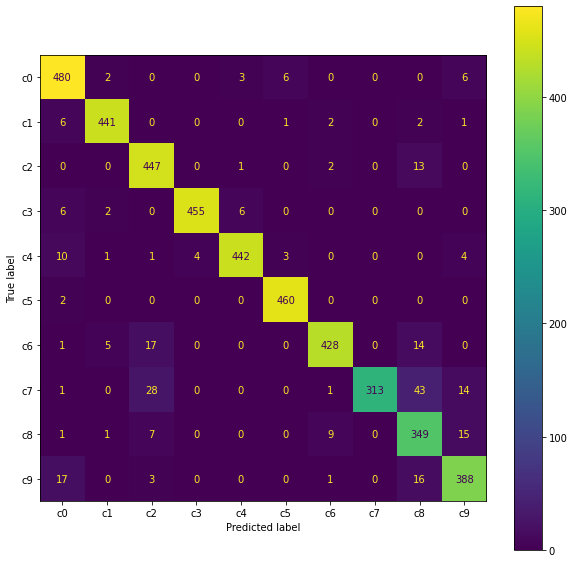

In [39]:
model.fit_model(model.vgg16, x_train, y_train, EPOCHS, BATCH_SIZE, VERBOSE)
model.evaluate_model(model.vgg16, x_test, y_test, BATCH_SIZE)

141/141 [==============================] - 2s 15ms/step - loss: 0.2067 - accuracy: 0.9380

Test lost: 0.20667368173599243 -- Test accuracy: 0.9379602670669556
281/281 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

          c0       0.92      0.97      0.94       497
          c1       0.98      0.97      0.97       453
          c2       0.89      0.97      0.93       463
          c3       0.99      0.97      0.98       469
          c4       0.98      0.95      0.96       465
          c5       0.98      1.00      0.99       462
          c6       0.97      0.92      0.94       465
          c7       1.00      0.78      0.88       400
          c8       0.80      0.91      0.85       382
          c9       0.91      0.91      0.91       425

    accuracy                           0.94      4481
   macro avg       0.94      0.94      0.94      4481
weighted avg       0.94      0.94      0.94      4481



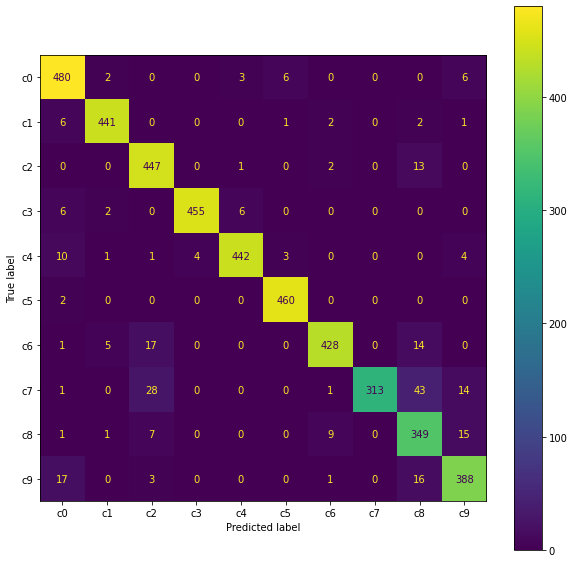

In [40]:
model.evaluate_model(model.vgg16, x_test, y_test, BATCH_SIZE)